# Beat the Streak

The game is hosted by MLB.com.  The goal is, each day, to choose a batter that gets a hit.  If the chosen batter gets a hit, your streak increases by one.  If the batter fails to get a hit your streak resets to zero.

# The Math

Your performance in the game can be modelled as a random process composed of a series of bernolli trials.  Either the batter gets a hit or he does not.

If we know the probablity of you choosing a batter correctly, we can estimate the expected value of the longest streak you will have given the number of days you get to choose batters.

That formula is given by: #TODO

We can estimate this probability of success by taking ratio of the number of successes you had to the  number of batters you thought would get hits.  The simplest strategy is to assume everyone will get a hit and choose uniformly from the batters playing today. Such a strategy will be a useful benchmark to evlauate the learning machines.

# The Retrosheet Data Files

The first step is to import the data from retrosheet.  http://www.retrosheet.org/game.htm hosts yearly game files in the zip archive format.  Each zip file contains a set of text files, one for each team.  In each file is a series of comma delimited rows that document the details of every play in each home game played by the team corresponding to the file.

The first field of the row declares the type of row, and for the purposes of this project we are interested in four types of rows:
1. info -- describes overall details about the game, such as temperature and date
2. start -- a starting player
3. sub -- a player substitution
4. play -- a play where the outcome is an event such as a hit, a walk, a strikeout, etc.

The first step of this project is to download and parse these text files into a fomat more useful for data analysis and machine learning.

In [1]:
import sqlite3
import zipfile
import re
import datetime
import os

dbfile = "retrosheet.db"

In [2]:

# The way the retrosheet data is stored, I need some variables to hold
# state data learned early in the file, for example visiting team name
# These data are not initalized. Instead I trust the file format to
# provide them all before I need them. These data will be stored in
# the following dicts and updated as encountered:
total_plays = 0
game = dict()
play = dict()
players = dict()
data_dir = 'project_data'
data_files = [data_dir+'/'+filename for filename in os.listdir(data_dir)]
db = sqlite3.connect(dbfile)
try:
    # We are going to build the table new every time.
    db.execute('DROP TABLE IF EXISTS plays')
    db.execute('''CREATE TABLE plays (
                    hit INTEGER,
                    bat_order INTEGER,
                    position INTEGER,
                    home INTEGER,
                    temp INTEGER,
                    starter INTEGER,
                    batter,
                    pitcher,
                    opp_team,
                    game_number,
                    year INTEGER,
                    day INTEGER)''')
    for filename in data_files:
        plays = 0
        print(filename, end="     ")
        with zipfile.ZipFile(filename, 'r') as zf:
            # Get the filenames of the files stored in the zip file. There are several
            # filetypes in the zip file, but I only need the event files, which end
            # with either .EVA or .EVN (American league or National league)
            filenames = [name for name in zf.namelist() if re.match('.*EV[AN]$', name)]
            for filename in filenames:
                # Read each file without extracting it from the zip archive and break
                # it into a list of lines
                lines = zf.read(filename).decode('utf8').splitlines()
                for line in lines:
                    # Each line is a comma separated list where the first column
                    # indicates the contents of the line
                    fields = line.strip().split(',')
                    # Interesting values in the first column are:
                    #     id - first line of a new game
                    #     info - details about the game overall
                    #     start - starting players
                    #     sub - player substitution
                    #     play - a baseball play
                    if fields[0] == 'info' and fields[1] in ('visteam','hometeam','date','starttime', 'temp', 'number'):
                        # When the record is 'info' the columns are:
                        #     1: info name
                        #     2: info value
                        if fields[1] == 'date':
                            game['year'] = datetime.date(*[int(a) for a in fields[2].split("/")]).timetuple().tm_year
                            game['day'] =  datetime.date(*[int(a) for a in fields[2].split("/")]).timetuple().tm_yday
                        else:
                            game[fields[1]] = fields[2]
                    if fields[0] in ('start','sub'):
                        # When record is 'start' or 'sub' columns are:
                        #     1: player id
                        #     2: player name
                        #     3: 1-home 0-visit
                        #     4: position in order
                        #     5: field position
                        if fields[1] not in players:
                            players[fields[1]] = dict()
                        players[fields[1]]['start'] = 1 if fields[0] == 'start' else 0
                        players[fields[1]]['position'] = fields[5]
                        players[fields[1]]['order'] = fields[4]
                        if fields[5] == '1':
                            if fields[3] == '1':
                                home_pitcher = fields[1]
                            else:
                                vis_pitcher = fields[1]
                    if fields[0] == 'play':
                        # When record is 'play':
                        #     1: inning
                        #     2: 1-home 0-visit
                        #     3: batter player id
                        #     4: count on the batter
                        #     5: all pitches to batter
                        #     6: outcome
                        if (fields[6][0:2] not in ('HP', 'PO', 'NP', 'BK', 'CS', 'DI', 'OA', 'PB', 'WP', 'SB', 'FL')
                            and fields[6][0] not in ('W', 'I', 'E', 'C')):
                            if fields[6][0] == 'K':
                                play['hit'] = 0
                            elif (fields[6][0:2] in ('FC')
                                or fields[6][0] in ('1', '2', '3', '4', '5', '6', '7', '8', '9')):
                                play['hit'] = 0
                            elif fields[6][0] in ('S', 'D', 'T', 'H'):
                                play['hit'] = 1
                            else:
                                assert False, "unknown play outcome: {}".format(fields[6])
                            play["game_number"] = game["number"]
                            play["home"] = fields[2]
                            play["starter"] = players[fields[3]]['start']
                            play["pitcher"] = vis_pitcher if play["home"] == '1' else home_pitcher
                            play["opp_team"] = game["visteam"] if play["home"] == '1' else game["hometeam"]
                            # FLO was renamed MIA in 2012.  Lets use MIA for everything
                            if play["opp_team"] == "FLO":
                                play["opp_team"] = "MIA"
                            play["batter"] = fields[3]
                            play["temp"] = game["temp"]
                            play["year"] = game["year"]
                            play["day"] = game["day"]
                            play["bat_order"] = players[fields[3]]['order']
                            play["position"] = players[fields[3]]['position']
                            assert play["batter"] != play["pitcher"], "huh?"
                            # Lets ignore pinch hitters and pinch runners
                            if play["position"] not in (11,12):
                                # I couldn't find any info on 0sao, and its only a few plays anyhow
                                if play["game_number"] != "0sao":
                                    plays += 1
                                    db.execute("INSERT INTO plays ({}) VALUES ({})".format(
                                        ','.join(play.keys()),
                                        ','.join(["'"+str(x)+"'" for x in play.values()])))
        print("plays:", plays)
        total_plays += plays
finally:
    db.commit()
    db.close()
    
print()
print("total plays:", total_plays)

project_data/2010eve.zip     plays: 166529
project_data/2011eve.zip     plays: 166947
project_data/2012eve.zip     plays: 166295
project_data/2013eve.zip     plays: 167199
project_data/2014eve.zip     plays: 166720
project_data/2015eve.zip     plays: 166370
project_data/2016eve.zip     plays: 166205

total plays: 1166265


# Verify the Play-by-Play Data

In [3]:
import pandas as pd
db = sqlite3.connect(dbfile)
try:
    df_plays = pd.read_sql_query('''
        SELECT
         *
        FROM plays
        LIMIT 5
        ''', db)
finally:
    db.close()

for c in df_plays.columns:
    print(c)
print()
    
df_plays

hit
bat_order
position
home
temp
starter
batter
pitcher
opp_team
game_number
year
day



,hit,bat_order,position,home,temp,starter,batter,pitcher,opp_team,game_number,year,day
0,0,1,8,0,58,1,spand001,weavj003,ANA,0,2010,95
1,0,2,4,0,58,1,hudso001,weavj003,ANA,0,2010,95
2,0,3,2,0,58,1,mauej001,weavj003,ANA,0,2010,95
3,0,2,9,1,58,1,abreb001,bakes002,MIN,0,2010,95
4,0,4,10,1,58,1,matsh001,bakes002,MIN,0,2010,95


# Estimate Days-per-Year with games

In [4]:
db = sqlite3.connect(dbfile)
try:
    df = pd.read_sql_query('''
        SELECT
            year,
            MAX(day) - MIN(day) days
        FROM plays
        GROUP BY year
        ''', db)
finally:
    db.close()
print(df)
print()
print(df.days.mean())

   year  days
0  2010   182
1  2011   181
2  2012   189
3  2013   183
4  2014   190
5  2015   182
6  2016   182

184.14285714285714


# Build the Game-by-Game Table

However Beat the Streak concerns game outcomes not play outcomes.  So we will group this table by the first four columns and take the max of the hit column (which will be either a one or a zero) as the result of the game. We will also simplify the year, day, game number columns by adding 0.5 to day if game_number is 2 and dropping the game_number column.

In [5]:
db = sqlite3.connect(dbfile)
try:
    df_games = pd.read_sql_query('''
        SELECT
            year,
            CASE
                WHEN game_number = "2"
                THEN day + 0.5
                ELSE day
                END day,
            temp,
            starter,
            home,
            opp_team,
            pitcher,
            bat_order,
            position,
            batter,
            COUNT(hit) n_plays,
            MAX(hit) y
        FROM plays
        GROUP BY year, day, game_number, batter
        ''', db)
    df_games.to_sql('games', db, index=False, if_exists='replace')
finally:
    db.commit()
    db.close()

    
def split_games(df):
    return (df[df.year <= 2014], df[df.year == 2015], df[df.year == 2016],)
    

for c in df_games.columns:
    print(c)
print()
    
df_games.head()

year
day
temp
starter
home
opp_team
pitcher
bat_order
position
batter
n_plays
y



,year,day,temp,starter,home,opp_team,pitcher,bat_order,position,batter,n_plays,y
0,2010,94.0,67,1,1,NYA,robed002,6,5,belta001,4,1
1,2010,94.0,67,1,1,NYA,sabac001,8,8,camem001,3,1
2,2010,94.0,67,1,0,BOS,beckj002,5,4,canor001,5,1
3,2010,94.0,67,1,1,NYA,sabac001,7,9,drewj001,4,1
4,2010,94.0,67,1,1,NYA,sabac001,1,7,ellsj001,5,0


This table of games comprises the fundamental dataset on which we will train and test. For the purposes of this project we will reserve 2016 for final testing and 2015 for model validation.  This means any statistics on players we derive will come exclusivly from the years 2010-2014.

Our first order of business is to determine our null success rate.  That is, the results of choosing batters randomly for the years 2015 and 2016.

# Null Rate

In [6]:
import numpy as np

df_train, df_2015, _unused = split_games(df_games)

print("train size:", df_train.shape[0])
print("2015 size:  ", df_2015.shape[0])
print()


# https://www.maa.org/sites/default/files/pdf/upload_library/22/Polya/07468342.di020742.02p0021g.pdf
# ERn = log_1/p (nq)
# therefore Ern = log_1/p (n(1-p))
# and log_u(a) = log_b(a) / log_b(u)
# thus
# ERn = log_b(n*(1-p)) / log_b(1/p)
# ERn = (log_b(n) + log_b(1-p)) / -log_b(p)
# ERn = -(log_b(n) + log_b(1-p)) / log_b(p)
def expected_streak(p, n):
    return np.log(n*(1-p)) / np.log(1/p)

def win_rate(df):
    daily_chance = 0
    pred_hits = 0
    days = df.day.unique()
    n_days = len(days)
    for day in df.day.unique():
        df_day = df[df.day==day]
        pred_hits += df_day.y.size
        daily_chance += df_day.y.sum()/df_day.y.size
    daily_chance /= n_days
    return n_days, pred_hits, daily_chance

n_days_2015, null_hits_2015, null_rate_2015 = win_rate(df_2015)
print("2015:   null rate: {:.3f}     null hits: {:.0f}     expected streak: {:.1f}".format(
    null_rate_2015, null_hits_2015, expected_streak(null_rate_2015, n_days_2015)))

train size: 251976
2015 size:   50748

2015:   null rate: 0.571     null hits: 50748     expected streak: 8.0


# Better than Average Batters

Now we have a null rate benchmark.  One very common strategy amoung beat the streak players is to choose only "good" batters, for exmaple batters with a batting average above a certain theshold. Let's see if this hypothesis bears out in the data and how it compares to the null rate. To do this, we will "train" on 2010-2014 to determine what an average batter is, and then choose above average batters only. Since we're estimating the rate form the data, we'll exclude batters with few samples.

In [7]:
from sklearn import preprocessing

db = sqlite3.connect(dbfile)
try:
    df_batter_stats = pd.read_sql_query('''
        SELECT
            1.0 * SUM(y) / COUNT(y) rate,
            COUNT(Y) batter_games,
            batter
        FROM games
        WHERE year NOT IN (2015, 2016)
        GROUP BY batter
        ''', db)
finally:
    db.close()

df_batter_stats = df_batter_stats[df_batter_stats.batter_games > 20]
df_merged = df_games.merge(df_batter_stats)
df_train, df_2015, _unused = split_games(df_merged)

scaler = preprocessing.StandardScaler()
features = ['rate',]
X1_raw = np.array(df_train[features])
y1 = np.array(df_train['y'])
scaler.fit(X1_raw)
X1 = scaler.transform(X1_raw)
X2 = scaler.transform(np.array(df_2015[features]))
y2 = np.array(df_2015['y'])

good_batters = (X2[:,0] > 0).astype(int)

print("train size:", df_train.shape[0])
print("2015 size:  ", df_2015.shape[0])
print()
_unused, hits_2015, rate_2015 = win_rate(df_2015[good_batters==1])
print("2015:   null rate: {:.3f}     null hits: {:.0f}     expected streak: {:.1f}".format(
    null_rate_2015, null_hits_2015, expected_streak(null_rate_2015, n_days_2015)))
print("2015:        rate: {:.3f}          hits: {:.0f}     expected streak: {:.1f}".format(
    rate_2015, hits_2015, expected_streak(rate_2015, n_days_2015)))

train size: 247674
2015 size:   43354

2015:   null rate: 0.571     null hits: 50748     expected streak: 8.0
2015:        rate: 0.629          hits: 28800     expected streak: 9.3


This simple test shows that knowledge of a batters history can improve (if slightly) the chance of choosing a successful batter each day, and thus improve the expected streak in the game "Beat the Streak". Now we want to find out if machine learning, and possibly more featurs can imporve the chances even further.

From this point forward, the year 2016 will not be considered until a final learning machine has been choosen.  At that point, the data from 2016 will be used to predict the performance of the machine in 2018, if someone wanted to use the final algorithm to actually play the game.

# Two Features

To start, so the data can be plotted and explored, we will use two features that are represented by continuous variables:
1. batters success rate
2. pitchers success rate

Also, since we are estimating this rate from the data, we will drop pitchers for which little data is availalbe.

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

db = sqlite3.connect(dbfile)
try:
    df_batter_stats = pd.read_sql_query('''
        SELECT
            1.0 * SUM(y) / COUNT(y) rate,
            COUNT(Y) batter_games,
            batter
        FROM games
        WHERE year NOT IN (2015, 2016)
        GROUP BY batter
        ''', db)
    df_pitcher_stats = pd.read_sql_query('''
        SELECT
            1.0 * SUM(y) / COUNT(y) vs_rate,
            COUNT(Y) pitcher_games,
            pitcher
        FROM games
        WHERE year NOT IN (2015, 2016)
        GROUP BY pitcher
        ''', db)
finally:
    db.close()

df_batter_stats = df_batter_stats[df_batter_stats.batter_games > 20]
df_pitcher_stats = df_pitcher_stats[df_pitcher_stats.pitcher_games > 20]
df_merged = df_games.merge(df_batter_stats).merge(df_pitcher_stats)
df_train, df_2015, _unused = split_games(df_merged)

scaler = preprocessing.StandardScaler()
features = ['rate', 'vs_rate']
X1_raw = np.array(df_train[features])
real_hits1 = np.array(df_train['y'])
scaler.fit(X1_raw)
X1 = scaler.transform(X1_raw)
X2 = scaler.transform(np.array(df_2015[features]))
real_hits2 = np.array(df_2015['y'])

print("train size:", df_train.shape[0])
print("2015 size:  ", df_2015.shape[0])
print()

train size: 245072
2015 size:   36879



This data suggests that a simple classifier will not be very helpful.  There is far too much overlap between the two classes in this feature space.  We could try to change the features or increase the dimensionality of the problem, but some experimenting has shown this strategy will be quit difficult.  In general the outcome of a play is mostly random so most of the feature space is filled with both hits and no hits.

However, perhaps some of the feature space is more dense with hits than with misses.  Your eye has problably already isolated the upper right corner where above average batters are facing below average pitchers. This suggests a possible learning stragegy.  Rather than try to separate the two classes, we will do unsupervised learning on what a miss is, and then look for anomolies or outliers.  These things that dont look like misses may have a higher probablity of being a hit.

We can extend this by learning what a hit is, and searching for things that are inliers to the hit machine and outliers to the miss machine.  We will explore this with the 2-d dataset here, and then apply it to a higher dimenional set that we can't visualize.

First let's isolate that corner in the training data by hand and see if it matters in the 2015 test data.

In [ ]:
linex = np.linspace(-2.5,1.5)
liney = -linex

p = 0.05
q = 0.2
X1_real_hits = X1[np.logical_and(real_hits1 == 1, np.random.rand(real_hits1.size) < p)]
X1_real_misses =  X1[np.logical_and(real_hits1 != 1, np.random.rand(real_hits1.size) < p)]
X2_real_hits =  X2[np.logical_and(real_hits2 == 1, np.random.rand(real_hits2.size) < q)]
X2_real_misses =  X2[np.logical_and(real_hits2 != 1, np.random.rand(real_hits2.size) < q)]

f, axarr = plt.subplots(2, figsize=(6,12), sharex=True)
axarr[0].plot(X1_real_hits[:,0], X1_real_hits[:,1], 'o', color='#000000', label='hit')
axarr[0].plot(X1_real_misses[:,0], X1_real_misses[:,1], 'x', color='#CCCCCC', label='miss')
axarr[0].plot(linex, liney, '--', color='#FFFFFF', linewidth=4)
axarr[1].plot(X2_real_hits[:,0], X2_real_hits[:,1], 'o', color='#000000', label='hit')
axarr[1].plot(X2_real_misses[:,0], X2_real_misses[:,1], 'x', color='#CCCCCC', label='miss')
axarr[1].plot(linex, liney, '--', color='#FFFFFF', linewidth=4)
axarr[1].set_ylim(axarr[0].get_ylim())
axarr[0].set_title('2010-2014 hits and misses')
axarr[1].set_title('2015 hits and misses')
axarr[1].set_xlabel('batter rate, normalized')
axarr[0].set_ylabel('pitcher rate, normalized')
axarr[1].set_ylabel('pitcher rate, normalized')
axarr[0].legend()
axarr[1].legend()

plt.savefig('two_features.pdf')

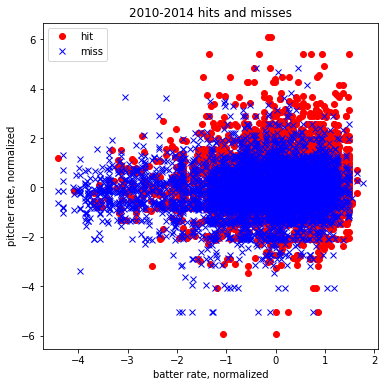

In [56]:
axarr = plt.figure(figsize=(6,6))
plt.plot(X1_real_hits[:,0], X1_real_hits[:,1], 'o', color='#FF0000', label='hit')
plt.plot(X1_real_misses[:,0], X1_real_misses[:,1], 'x', color='#0000FF', label='miss')
#plt.plot(linex, liney, '--', color='#00FF00', linewidth=4)
#axarr[1].plot(X2_real_hits[:,0], X2_real_hits[:,1], 'o', color='#FF0000', label='hit')
#axarr[1].plot(X2_real_misses[:,0], X2_real_misses[:,1], 'x', color='#0000FF', label='miss')
#axarr[1].plot(linex, liney, '--', color='#00FF00', linewidth=4)
plt.title('2010-2014 hits and misses')
#axarr[1].set_title('2015 hits and misses')
plt.xlabel('batter rate, normalized')
plt.ylabel('pitcher rate, normalized')
#axarr[1].set_ylabel('pitcher rate, normalized')
plt.legend()
#axarr[1].legend()

plt.savefig('two_features_color2.pdf')

# Better than Average Batters and Worse than Average Pitchers

In [10]:
good_matches_2015 = (X2[:,0] + X2[:,1] > 0).astype(int)

_unused, hits_2015, rate_2015 = win_rate(df_2015[good_matches_2015==1])
print("2015:   null rate: {:.3f}     null hits: {:.0f}     expected streak: {:.1f}".format(
    null_rate_2015, null_hits_2015, expected_streak(null_rate_2015, n_days_2015)))
print("2015:        rate: {:.3f}          hits: {:.0f}     expected streak: {:.1f}".format(
    rate_2015, hits_2015, expected_streak(rate_2015, n_days_2015)))

2015:   null rate: 0.571     null hits: 50748     expected streak: 8.0
2015:        rate: 0.631          hits: 19675     expected streak: 9.4


Great!  That corner has a significant impact on the chance of choosing a successful batter.

Now lets see if the learning machines can find the same corner. We'll start by looking for things that aren't misses.

# Learning from Two Features

In [11]:
from sklearn import svm

2015:   null rate: 0.571     null hits: 50748     expected streak: 8.0

Not Misses:
2015:        rate: 0.810          hits: 21     expected streak: 17.2

Hits:
2015:        rate: 0.583          hits: 36857     expected streak: 8.2



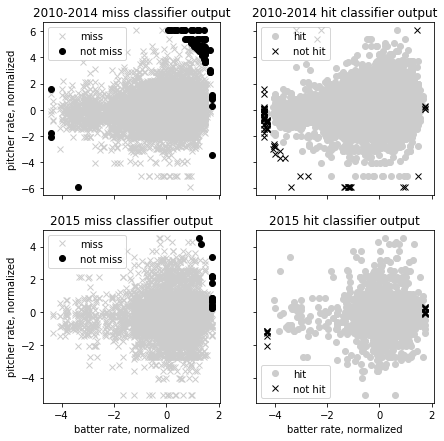

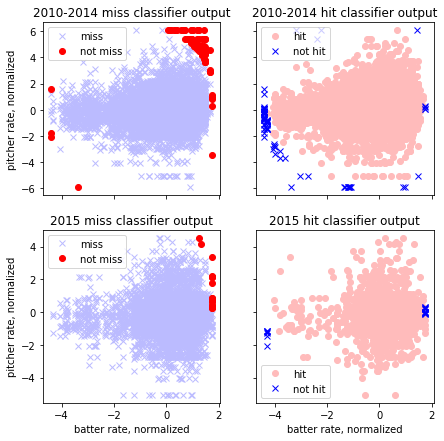

In [12]:
p = 0.05
q = 0.2
miss_clf = svm.OneClassSVM(kernel='rbf', nu=0.00005, gamma=0.05)
miss_clf.fit(X1[real_hits1 == 0])
miss_pred1 = (miss_clf.predict(X1) > 0).astype(int)
miss_pred2 = (miss_clf.predict(X2) > 0).astype(int)
X1_miss = X1[np.logical_and(miss_pred1 == 1, np.random.rand(miss_pred1.size) < p)]
X1_not_miss = X1[miss_pred1 == 0]
X2_miss = X2[np.logical_and(miss_pred2 == 1, np.random.rand(miss_pred2.size) < q)]
X2_not_miss = X2[miss_pred2 == 0]


hit_clf = svm.OneClassSVM(kernel='rbf', nu=0.00005, gamma=0.05)
hit_clf.fit(X1[real_hits1 == 1])
hit_pred1 = (hit_clf.predict(X1) > 0).astype(int)
hit_pred2 = (hit_clf.predict(X2) > 0).astype(int)
X1_hit = X1[np.logical_and(hit_pred1 == 1, np.random.rand(hit_pred1.size) < p)]
X1_not_hit = X1[hit_pred1 == 0]
X2_hit = X2[np.logical_and(hit_pred2 == 1, np.random.rand(hit_pred2.size) < p)]
X2_not_hit = X2[hit_pred2 == 0]

_unused, hits_2015, rate_2015 = win_rate(df_2015[miss_pred2 == 0])
print("2015:   null rate: {:.3f}     null hits: {:.0f}     expected streak: {:.1f}".format(
    null_rate_2015, null_hits_2015, expected_streak(null_rate_2015, n_days_2015)))
print("\nNot Misses:")
print("2015:        rate: {:.3f}          hits: {:.0f}     expected streak: {:.1f}".format(
    rate_2015, hits_2015, expected_streak(rate_2015, n_days_2015)))
_unused, hits_2015, rate_2015 = win_rate(df_2015[hit_pred2 == 1])
print("\nHits:")
print("2015:        rate: {:.3f}          hits: {:.0f}     expected streak: {:.1f}".format(
    rate_2015, hits_2015, expected_streak(rate_2015, n_days_2015)))
print()

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(7,7))
ax1.plot(X1_miss[:,0], X1_miss[:,1], 'x', color='#CCCCCC', label='miss')
ax1.plot(X1_not_miss[:,0], X1_not_miss[:,1], 'o', color='#000000', label='not miss')
ax1.set_title('2010-2014 miss classifier output')
ax2.plot(X1_hit[:,0], X1_hit[:,1], 'o', color='#CCCCCC', label='hit')
ax2.plot(X1_not_hit[:,0], X1_not_hit[:,1], 'x', color='#000000', label='not hit')
ax2.set_title('2010-2014 hit classifier output')
ax3.plot(X2_miss[:,0], X2_miss[:,1], 'x', color='#CCCCCC', label='miss')
ax3.plot(X2_not_miss[:,0], X2_not_miss[:,1], 'o', color='#000000', label='not miss')
ax3.set_title('2015 miss classifier output')
ax4.plot(X2_hit[:,0], X2_hit[:,1], 'o', color='#CCCCCC', label='hit')
ax4.plot(X2_not_hit[:,0], X2_not_hit[:,1], 'x', color='#000000', label='not hit')
ax4.set_title('2015 hit classifier output')


ax3.set_xlabel('batter rate, normalized')
ax4.set_xlabel('batter rate, normalized')
ax1.set_ylabel('pitcher rate, normalized')
ax3.set_ylabel('pitcher rate, normalized')
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.savefig('oneclass_svm_output.pdf')

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(7,7))
ax1.plot(X1_miss[:,0], X1_miss[:,1], 'x', color='#BBBBFF', label='miss')
ax1.plot(X1_not_miss[:,0], X1_not_miss[:,1], 'o', color='#FF0000', label='not miss')
ax1.set_title('2010-2014 miss classifier output')
ax2.plot(X1_hit[:,0], X1_hit[:,1], 'o', color='#FFBBBB', label='hit')
ax2.plot(X1_not_hit[:,0], X1_not_hit[:,1], 'x', color='#0000FF', label='not hit')
ax2.set_title('2010-2014 hit classifier output')
ax3.plot(X2_miss[:,0], X2_miss[:,1], 'x', color='#BBBBFF', label='miss')
ax3.plot(X2_not_miss[:,0], X2_not_miss[:,1], 'o', color='#FF0000', label='not miss')
ax3.set_title('2015 miss classifier output')
ax4.plot(X2_hit[:,0], X2_hit[:,1], 'o', color='#FFBBBB', label='hit')
ax4.plot(X2_not_hit[:,0], X2_not_hit[:,1], 'x', color='#0000FF', label='not hit')
ax4.set_title('2015 hit classifier output')


ax3.set_xlabel('batter rate, normalized')
ax4.set_xlabel('batter rate, normalized')
ax1.set_ylabel('pitcher rate, normalized')
ax3.set_ylabel('pitcher rate, normalized')
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.savefig('oneclass_svm_output_color.pdf')

# Combining the Two Outputs

2015:   null rate: 0.571     null hits: 50748.0     expected streak: 8.0
2015:        rate: 0.824          hits: 17.0     expected streak: 18.4


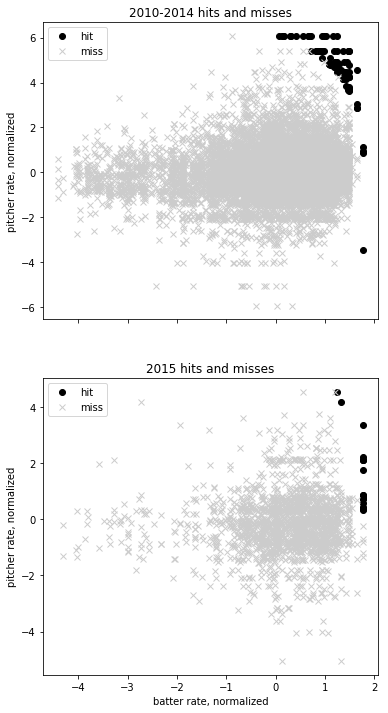

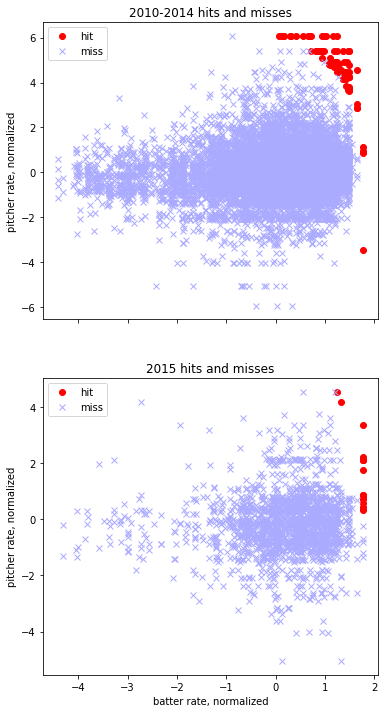

In [13]:
p = 0.05
q = 0.2

comb_hit1 = np.logical_and(hit_pred1 == 1, miss_pred1 != 1).astype(int)
comb_hit2 = np.logical_and(hit_pred2 == 1 , miss_pred2 != 1).astype(int)

X1_comb_hit = X1[comb_hit1 == 1]
X1_comb_miss = X1[np.logical_and(comb_hit1 != 1, np.random.rand(comb_hit1.size) < p)]
X2_comb_hit = X2[comb_hit2 == 1]
X2_comb_miss = X2[np.logical_and(comb_hit2 != 1, np.random.rand(comb_hit2.size) < p)]

_unused, hits_2015, rate_2015 = win_rate(df_2015[comb_hit2==1])
print("2015:   null rate: {:.3f}     null hits: {:.1f}     expected streak: {:.1f}".format(
    null_rate_2015, null_hits_2015, expected_streak(null_rate_2015, n_days_2015)))
print("2015:        rate: {:.3f}          hits: {:.1f}     expected streak: {:.1f}".format(
    rate_2015, hits_2015, expected_streak(rate_2015, n_days_2015)))


f, axarr = plt.subplots(2, figsize=(6,12), sharex=True)
axarr[0].plot(X1_comb_hit[:,0], X1_comb_hit[:,1], 'o', color='#000000', label='hit')
axarr[0].plot(X1_comb_miss[:,0], X1_comb_miss[:,1], 'x', color='#CCCCCC', label='miss')
axarr[1].plot(X2_comb_hit[:,0], X2_comb_hit[:,1], 'o', color='#000000', label='hit')
axarr[1].plot(X2_comb_miss[:,0], X2_comb_miss[:,1], 'x', color='#CCCCCC', label='miss')
axarr[0].set_title('2010-2014 hits and misses')
axarr[1].set_title('2015 hits and misses')
axarr[1].set_xlabel('batter rate, normalized')
axarr[0].set_ylabel('pitcher rate, normalized')
axarr[1].set_ylabel('pitcher rate, normalized')
axarr[0].legend()
axarr[1].legend()

plt.savefig('combined_classifier.pdf')

f, axarr = plt.subplots(2, figsize=(6,12), sharex=True)
axarr[0].plot(X1_comb_hit[:,0], X1_comb_hit[:,1], 'o', color='#FF0000', label='hit')
axarr[0].plot(X1_comb_miss[:,0], X1_comb_miss[:,1], 'x', color='#AAAAFF', label='miss')
axarr[1].plot(X2_comb_hit[:,0], X2_comb_hit[:,1], 'o', color='#FF0000', label='hit')
axarr[1].plot(X2_comb_miss[:,0], X2_comb_miss[:,1], 'x', color='#AAAAFF', label='miss')
axarr[0].set_title('2010-2014 hits and misses')
axarr[1].set_title('2015 hits and misses')
axarr[1].set_xlabel('batter rate, normalized')
axarr[0].set_ylabel('pitcher rate, normalized')
axarr[1].set_ylabel('pitcher rate, normalized')
axarr[0].legend()
axarr[1].legend()

plt.savefig('combined_classifier_color.pdf')

Success!  We have built a learning machine that can imporve your odds of winning "Beat the Streak"! The leanring machine did better than the by hand estimate of the target region.

# More Features

In [14]:
db = sqlite3.connect(dbfile)
try:
    df_batter_stats = pd.read_sql_query('''
        SELECT
            1.0 * SUM(y) / COUNT(y) rate,
            1.0 * SUM(n_plays) / COUNT(y) ppg,
            COUNT(Y) batter_games,
            batter
        FROM games
        WHERE year NOT IN (2015, 2016)
        GROUP BY batter
        ''', db)
    df_pitcher_stats = pd.read_sql_query('''
        SELECT
            1.0 * SUM(y) / COUNT(y) vs_rate,
            COUNT(Y) pitcher_games,
            pitcher
        FROM games
        WHERE year NOT IN (2015, 2016)
        GROUP BY pitcher
        ''', db)
finally:
    db.close()

df_batter_stats = df_batter_stats[df_batter_stats.batter_games > 20]
df_pitcher_stats = df_pitcher_stats[df_pitcher_stats.pitcher_games > 20]
df_merged = df_games.merge(df_batter_stats).merge(df_pitcher_stats)
df_train, df_2015, df_2016 = split_games(df_merged)
df_train.head()

,year,day,temp,starter,home,opp_team,pitcher,bat_order,position,batter,n_plays,y,rate,ppg,batter_games,vs_rate,pitcher_games
0,2010,94.0,67,1,1,NYA,robed002,6,5,belta001,4,1,0.751687,3.858300,741,0.67,200
1,2010,127.0,68,1,1,NYA,robed002,6,5,belta001,4,1,0.751687,3.858300,741,0.67,200
2,2013,228.0,79,1,1,NYA,robed002,1,8,ellsj001,5,1,0.732075,4.150943,530,0.67,200
4,2011,92.0,52,1,0,NYA,robed002,5,10,martv001,4,1,0.743986,3.786942,582,0.67,200
9,2010,128.0,54,1,1,NYA,robed002,2,4,pedrd001,3,1,0.733931,4.037369,669,0.67,200


In [15]:
scaler = preprocessing.StandardScaler()
features = ['rate', 'vs_rate', 'ppg', 'temp', 'starter']
X1_raw = np.array(df_train[features])
y1 = np.array(df_train['y'])
scaler.fit(X1_raw)
X1 = scaler.transform(X1_raw)
X2 = scaler.transform(np.array(df_2015[features]))
y2 = np.array(df_2015['y'])
X3 = scaler.transform(np.array(df_2016[features]))
y3 = np.array(df_2016['y'])

In [16]:
print("train size:", df_train.shape[0])
print("2015 size:  ", df_2015.shape[0])
print()

A1 = y1 == 1
B1 = y1 == 0
A2 = y2 == 1
B2 = y2 == 0

miss_clf = svm.OneClassSVM(kernel='rbf', nu=0.0005, gamma=0.05)
miss_clf.fit(X1[y1 == 0])

miss_pred1 = miss_clf.predict(X1)
miss_pred2 = miss_clf.predict(X2)

y1hat = (miss_pred1 < 0).astype(int)
y2hat = (miss_pred2 < 0).astype(int)

A1 = y1hat == 1
B1 = y1hat == 0
A2 = y2hat == 1
B2 = y2hat == 0

_unused, hits_2015, rate_2015 = win_rate(df_2015[y2hat==1])
print("2015:   null rate: {:.3f}     null hits: {:.0f}     expected streak: {:.1f}".format(
    null_rate_2015, null_hits_2015, expected_streak(null_rate_2015, n_days_2015)))
print("2015:        rate: {:.3f}          hits: {:.0f}     expected streak: {:.1f}".format(
    rate_2015, hits_2015, expected_streak(rate_2015, n_days_2015)))


hit_clf = svm.OneClassSVM(kernel='rbf', nu=0.0005, gamma=0.05)
hit_clf.fit(X1[y1 == 1])

hit_pred1 = hit_clf.predict(X1)
hit_pred2 = hit_clf.predict(X2)

y1hat = (hit_pred1 > 0).astype(int)
y2hat = (hit_pred2 > 0).astype(int)

A1 = y1hat == 1
B1 = y1hat == 0
A2 = y2hat == 1
B2 = y2hat == 0

_unused, hits_2015, rate_2015 = win_rate(df_2015[y2hat==1])
print("2015:        rate: {:.3f}          hits: {:.0f}     expected streak: {:.1f}".format(
    rate_2015, hits_2015, expected_streak(rate_2015, n_days_2015)))

y1hat = np.logical_and(hit_pred1 > 0, miss_pred1 < 0).astype(int)
y2hat = np.logical_and(hit_pred2 > 0, miss_pred2 < 0).astype(int)

A1 = y1hat == 1
B1 = y1hat == 0
A2 = y2hat == 1
B2 = y2hat == 0

_unused, hits_2015, rate_2015 = win_rate(df_2015[y2hat==1])
print("2015:        rate: {:.3f}          hits: {:.0f}     expected streak: {:.1f}".format(
    rate_2015, hits_2015, expected_streak(rate_2015, n_days_2015)))

train size: 245072
2015 size:   36879

2015:   null rate: 0.571     null hits: 50748     expected streak: 8.0
2015:        rate: 0.837          hits: 59     expected streak: 19.6
2015:        rate: 0.583          hits: 36851     expected streak: 8.2
2015:        rate: 0.944          hits: 43     expected streak: 42.2


# Final Test on 2016

Now we have settled on a feature set and a learning machine algorithm, and we will test these on the 2016 data to try to estimate the performance on future years using this strategy.

In [17]:
n_days_2016, null_hits_2016, null_rate_2016 = win_rate(df_2016)
print("2016:   null rate: {:.3f}     null hits: {:.0f}     expected streak: {:.1f}".format(
    null_rate_2016, null_hits_2016, expected_streak(null_rate_2016, n_days_2016)))

miss_pred3 = miss_clf.predict(X3)
y3hat = (miss_pred3 < 0).astype(int)
_unused, hits_2016, rate_2016 = win_rate(df_2016[y3hat==1])
print("2016:        rate: {:.3f}          hits: {:.0f}     expected streak: {:.1f}".format(
    rate_2016, hits_2016, expected_streak(rate_2016, n_days_2016)))

hit_pred3 = hit_clf.predict(X3)
y3hat = (hit_pred3 > 0).astype(int)
_unused, hits_2016, rate_2016 = win_rate(df_2016[y3hat==1])
print("2016:        rate: {:.3f}          hits: {:.0f}     expected streak: {:.1f}".format(
    rate_2016, hits_2016, expected_streak(rate_2016, n_days_2016)))

y3hat = np.logical_and(hit_pred3 > 0, miss_pred3 < 0).astype(int)
_unused, hits_2016, rate_2016 = win_rate(df_2016[y3hat==1])
print("2016:        rate: {:.3f}          hits: {:.0f}     expected streak: {:.1f}".format(
    rate_2016, hits_2016, expected_streak(rate_2016, n_days_2016)))

2016:   null rate: 0.593     null hits: 27489     expected streak: 8.3
2016:        rate: 0.812          hits: 49     expected streak: 17.2
2016:        rate: 0.593          hits: 27445     expected streak: 8.3
2016:        rate: 0.958          hits: 28     expected streak: 48.9


# Conclusions

Succes!  The learning machine was able to improve the odds of winning beat the streak by training on old data and finding conditions under which a hit was more likely than average.

In [34]:
N = 184
p = 0.972
print(-np.log(N-N*p)/np.log(p))

57.7258916375


In [35]:
p**57

0.19814225478667985